In [3]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import MinMaxScaler

In [4]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/code/train_ohe.csv'
test_path  = '/data/ephemeral/home/code/test_ohe.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [5]:
import re

# 피처 이름 정리 함수(모델에 들어갔을 때 오류 방지지)
def clean_column_names(columns):
    cleaned_columns = []
    for col in columns:
        # 특수 문자와 공백을 _로 대체
        col = re.sub(r'[^\w\s]', '_', col)  # 특수 문자 제거
        col = re.sub(r'\s+', '_', col)  # 공백을 _로 대체
        col = col.strip('_')  # 앞뒤 언더스코어 제거
        cleaned_columns.append(col)
    return cleaned_columns

# 데이터프레임 열 이름 변환
dt.columns = clean_column_names(dt.columns)
dt_test.columns = clean_column_names(dt_test.columns)
# 확인
print(dt.columns)

Index(['층', '건축년도', '등기신청일자', 'target', '계약년도', '성수기여부', '전용면적', '중개거래', '직거래',
       '도시형_생활주택_아파트', '도시형_생활주택_주상복합', '아파트', '연립주택', '주상복합', '분양', '분양형태_기타',
       '임대', '위탁관리', '자치관리', '직영', '계단식', '복도식', '복도유형_기타', '타워형', '혼합식',
       '개별난방', '난방방식_기타', '중앙난방', '지역난방', '전용면적별세대현황_60_이하',
       '전용면적별세대현황_60__85_이하', '85__135_이하', '135_초과', '경비비관리형태_기타', '위탁',
       '위탁_직영', '직영_1', '단일계약', '종합계약', '위탁_1', '위탁_직영_1', '직영_2',
       '청소비관리형태_기타', '기타', '의무', '임대_1', '임의', '학군_강남서초', '학군_강동송파', '학군_강서양천',
       '학군_남부', '학군_동부', '학군_동작관악', '학군_북부', '학군_서부', '학군_성동광진', '학군_성북강북',
       '학군_성북광북', '학군_중부', '구_강남구', '구_강동구', '구_강북구', '구_강서구', '구_관악구',
       '구_광진구', '구_구로구', '구_금천구', '구_노원구', '구_도봉구', '구_동대문구', '구_동작구', '구_마포구',
       '구_서대문구', '구_서초구', '구_성동구', '구_성북구', '구_송파구', '구_양천구', '구_영등포구',
       '구_용산구', '구_은평구', '구_종로구', '구_중구', '구_중랑구'],
      dtype='object')


In [6]:
# Target과 독립변수들을 분리해줍니다.
# y_train = dt['target']
y_train = np.log1p(dt['target'])
X_train = dt.drop(['target'], axis=1)

In [7]:
# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## General XGBoost


In [9]:
# XGBoost 모델 생성
xgb_model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=25,
    n_estimators=50,
    use_label_encoder=False,
    eval_metric='rmse',
    random_state=42,  
)

In [10]:
# 모델 학습
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=25, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
# 예측 및 평가
y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1189


In [12]:
# 학습한 모델을 저장합니다.
import joblib
joblib.dump(xgb_model, 'xgb_ohe_data_1231_logtarget.pkl')

['xgb_ohe_data_1231_logtarget.pkl']

In [13]:
# 저장된 모델 정보 불러오기
model = joblib.load("xgb_ohe_data_1231_logtarget.pkl")

In [14]:
%%time
#X_test = dt_test.drop(['target'], axis=1)
X_test = dt_test

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

real_test_pred = np.expm1(real_test_pred)

CPU times: user 206 ms, sys: 7.91 ms, total: 213 ms
Wall time: 42.5 ms


In [15]:
print(real_test_pred)          # 예측값들이 출력됨을 확인할 수 있습니다.

[169395.78  244245.77  284782.22  ...  91136.53   70156.69   65258.273]


In [16]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_xgb_ohe_data_1231_logtarget.csv', index=False)

## XGBoost Gridsearch

In [17]:
# XGBoost 모델 생성
xgb_model = xgb.XGBRegressor(random_state=42)

# XGBoost 하이퍼파라미터 그리드
xgb_param_grid = {
    'n_estimators': [25, 50,75],
    'learning_rate': [0.01, 0.1],
    'max_depth': [10, 25],
}

# XGBoost에 GridSearchCV 적용
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
xgb_grid_search.fit(X_train, y_train)

print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best score for XGBoost:", xgb_grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 75}
Best score for XGBoost: -0.015523781648334066


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 50}

In [18]:
best_model = xgb_grid_search.best_estimator_
best_params = xgb_grid_search.best_params_

In [19]:
# 예측 및 평가
y_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1181


In [20]:
# 학습한 모델을 저장합니다.
import joblib
# 모델과 하이퍼파라미터를 함께 저장
model_info = {
    "model": best_model,
    "hyperparameters": best_params
}
joblib.dump(model_info, 'xgb_ohe_data_1231_logtarget_2.pkl')

['xgb_ohe_data_1231_logtarget_2.pkl']

In [22]:
# 저장된 모델 정보 불러오기
loaded_info = joblib.load("xgb_ohe_data_1231_logtarget_2.pkl")

# 모델과 하이퍼파라미터 분리
loaded_model = loaded_info["model"]
loaded_params = loaded_info["hyperparameters"]

print("Loaded hyperparameters:", loaded_params)

Loaded hyperparameters: {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 75}


In [23]:
%%time
#X_test = dt_test.drop(['target'], axis=1)
X_test = dt_test

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = loaded_model.predict(X_test)

real_test_pred = np.expm1(real_test_pred)

CPU times: user 321 ms, sys: 0 ns, total: 321 ms
Wall time: 51.9 ms


In [24]:
print(real_test_pred)          # 예측값들이 출력됨을 확인할 수 있습니다.

[169506.95  245861.34  285992.28  ...  91828.83   70115.82   65393.902]


In [25]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_xgb_ohe_data_1231_logtarget_2.csv', index=False)

In [19]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.feature_importances_, index=X_train.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

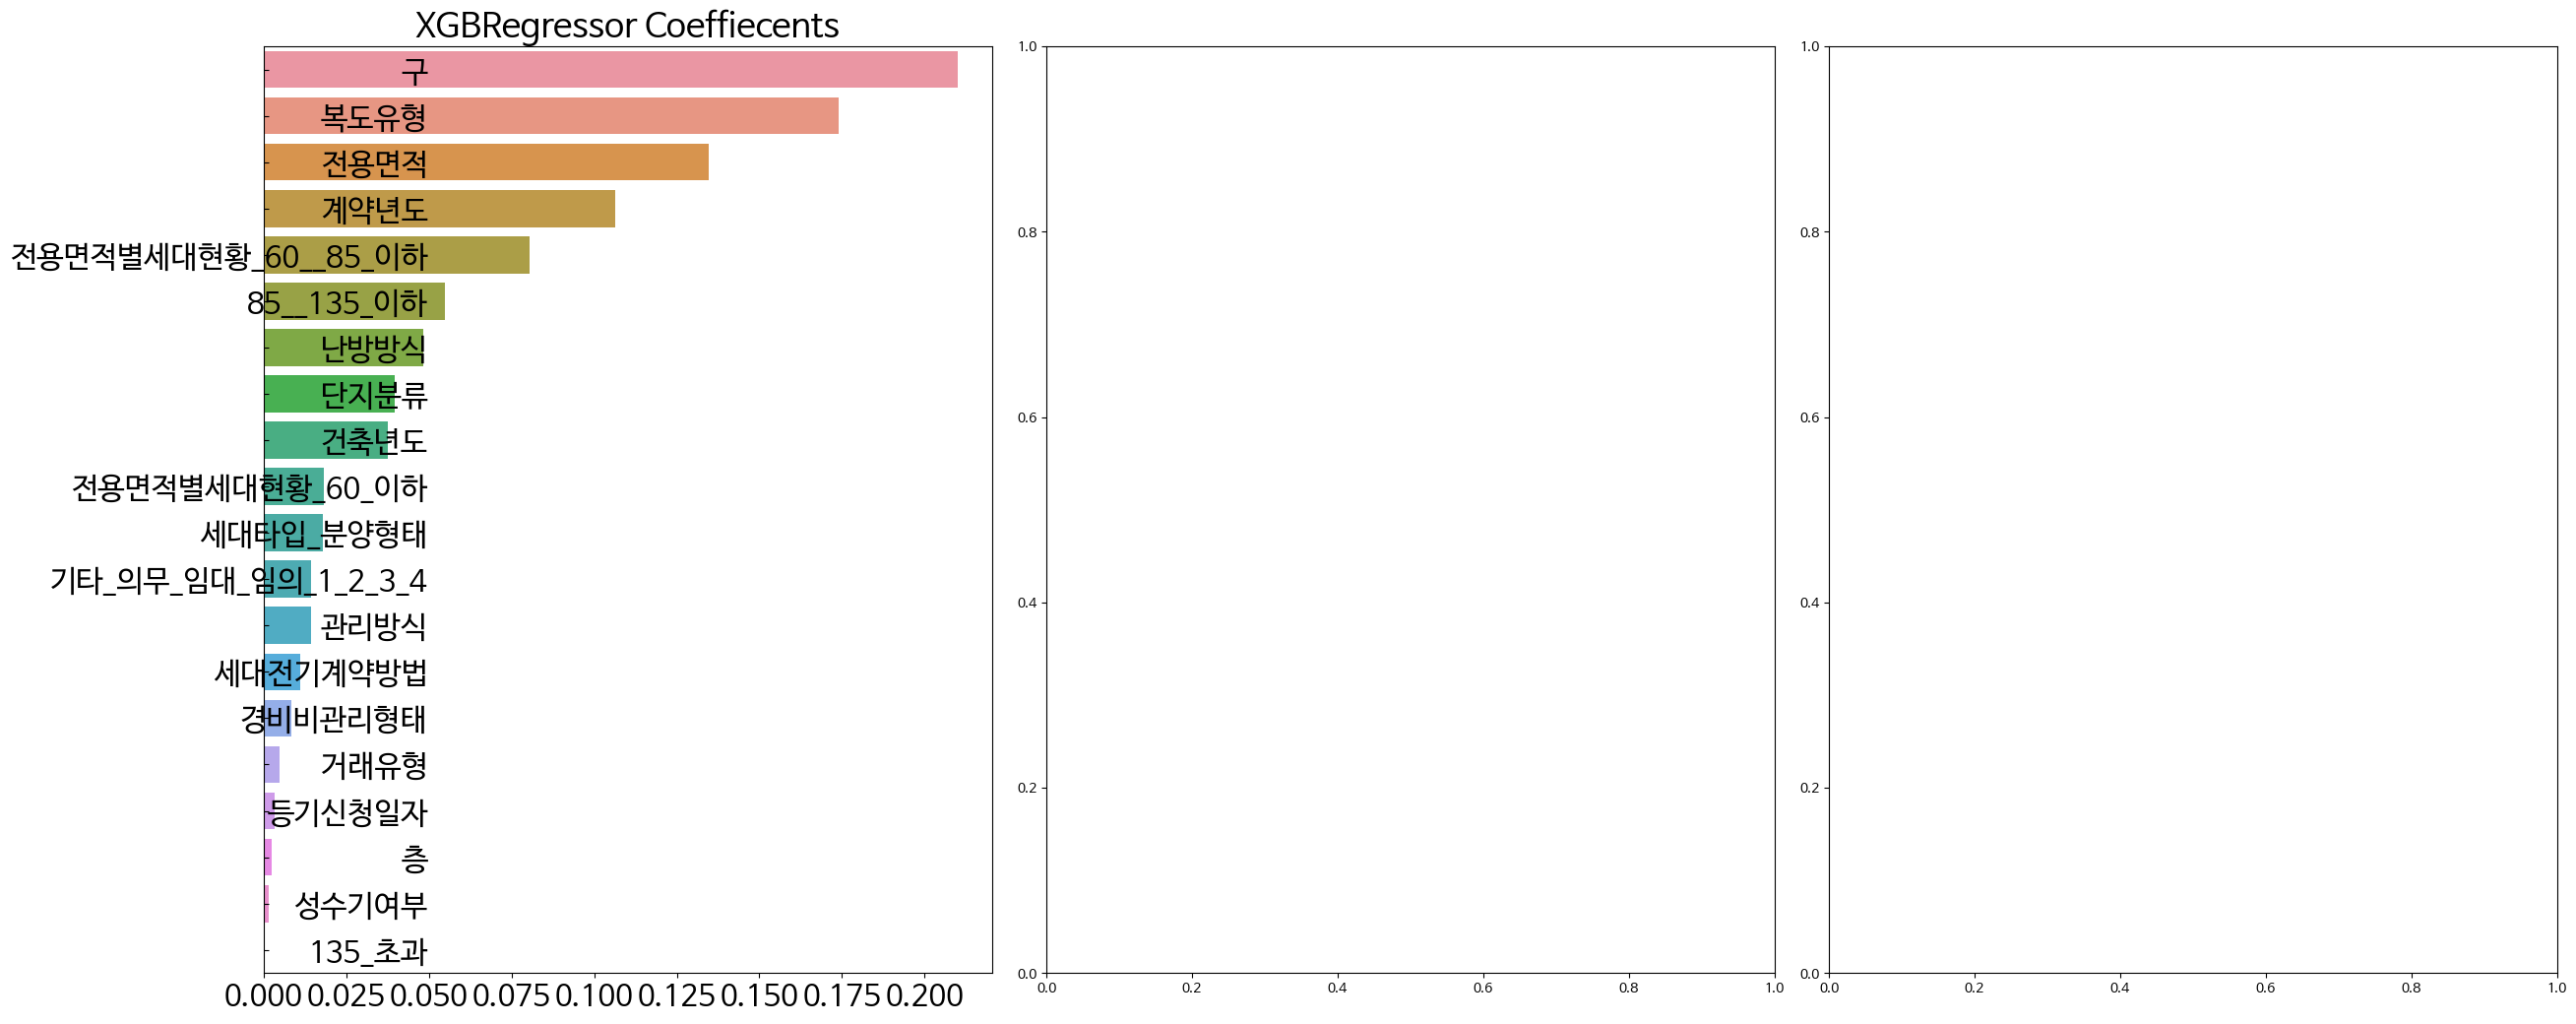

In [20]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [loaded_model]
visualize_coefficient(models)

## LightGBM Gridsearch

In [ ]:
# LightGBM 모델 생성
lgb_model = lgb.LGBMRegressor()

# LightGBM 하이퍼파라미터 그리드
lgb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
}

# LightGBM에 GridSearchCV 적용
lgb_grid_search = GridSearchCV(lgb_model, lgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
lgb_grid_search.fit(X_train, y_train)

print("Best parameters for LightGBM:", lgb_grid_search.best_params_)
print("Best score for LightGBM:", lgb_grid_search.best_score_)